# Exploratory Data Analysis

## Importing libraries and data

In [116]:
import os
import glob
import functools
import gc
    
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn
import cufflinks

cufflinks.go_offline()
        
import missingno as msno
import psycopg2
from dotenv import load_dotenv

load_dotenv()

conn = psycopg2.connect(user=os.getenv("DB_USER"),
                        password=os.getenv("DB_PASSWORD"),
                        host="127.0.0.1",
                        port="5432",
                        database="nyc-metro")

In [21]:
df = pd.read_csv('../data/raw/2014.csv.gz', engine='c', parse_dates=['time'])
df.head(5)

,time,ca,unit,scp,station,linename,division,desc,entries,exits
0,2014-01-01,A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,REGULAR,4428384.0,1509634.0
1,2014-01-01,A002,R051,02-00-01,LEXINGTON AVE,456NQR,BMT,REGULAR,4151140.0,904204.0
2,2014-01-01,A002,R051,02-03-00,LEXINGTON AVE,456NQR,BMT,REGULAR,238953.0,857726.0
3,2014-01-01,A002,R051,02-03-01,LEXINGTON AVE,456NQR,BMT,REGULAR,4050573.0,6322080.0
4,2014-01-01,A002,R051,02-03-02,LEXINGTON AVE,456NQR,BMT,REGULAR,3789717.0,5210513.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7420384 entries, 0 to 7420383
Data columns (total 10 columns):
 #   Column    Dtype         
---  ------    -----         
 0   time      datetime64[ns]
 1   ca        object        
 2   unit      object        
 3   scp       object        
 4   station   object        
 5   linename  object        
 6   division  object        
 7   desc      object        
 8   entries   float64       
 9   exits     float64       
dtypes: datetime64[ns](1), float64(2), object(7)
memory usage: 566.1+ MB


## Introduction

This dataset has information about NYC metro stations regarding entries and exits of people recorded in turnstiles. The dataset is supplied by MTA, from their website:

> The Metropolitan Transportation Authority is North America's largest transportation network, serving a population of 15.3 million people across a 5,000-square-mile travel area surrounding New York City through Long Island, southeastern New York State, and Connecticut.

From test case, our major goal is defined as:

> Forecast the number of people that uses the metro. You can let the imagination work and do this the way you prefer, chosing the temporal/spatial sampling rate (by station/turnstile, day/hour/week etc). This choice is part of the challenge.

Since this is a typical data science process, I will use CRISP-DM methodology to refine my process.

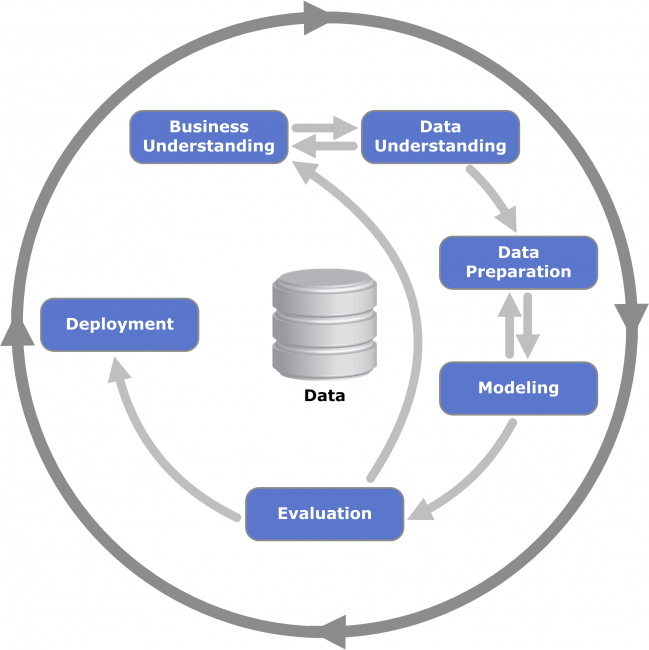

## Business Understanding

Usually, we do business understading talking to the analysts facing the problem they want help with. Since this is a simulation, the best thing I can do is to research about data to help me accelerate process at the time I am doing Data Understanding. We also have a description for our data that will be extremely useful:

### Field Description

C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS


- **C/A**: Control Area (A002)
- **UNIT**: Remote Unit for a station (R051)
- **SCP**: Subunit Channel Position represents an specific address for a device (02-00-00)
- **STATION**: Represents the station name the device is located at
- **LINENAME**: Represents all train lines that can be boarded at this station
           Normally lines are represented by one character.  LINENAME 456NQR repersents train server for 4, 5, 6, N, Q, and R trains.
- **DIVISION**: Represents the Line originally the station belonged to BMT, IRT, or IND   
- **DATE**: Represents the date (MM-DD-YY)
- **TIME**: Represents the time (hh:mm:ss) for a scheduled audit event
- **DESC**: Represent the "REGULAR" scheduled audit event (Normally occurs every 4 hours)
           1. Audits may occur more that 4 hours due to planning, or troubleshooting activities. 
           2. Additionally, there may be a "RECOVR AUD" entry: This refers to a missed audit that was recovered. 
- **ENTRIES**: The comulative entry register value for a device
- **EXIST**: The cumulative exit register value for a device



**Example:
The data below shows the entry/exit register values for one turnstile at control area (A002) for 2010-04-17 04:00:00**

In [4]:
df[(df['ca']=='A002') & (df['time']==pd.to_datetime('2010-04-17 08:00:00'))].head(10)

,time,ca,unit,scp,station,linename,division,desc,entries,exits
4795,2010-04-17 08:00:00,A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,REGULAR,2704723.0,928795.0
4796,2010-04-17 08:00:00,A002,R051,02-00-01,LEXINGTON AVE,456NQR,BMT,REGULAR,2697639.0,566683.0
4797,2010-04-17 08:00:00,A002,R051,02-03-00,LEXINGTON AVE,456NQR,BMT,REGULAR,1127725.0,3943518.0
4798,2010-04-17 08:00:00,A002,R051,02-03-01,LEXINGTON AVE,456NQR,BMT,REGULAR,2425588.0,3733323.0
4799,2010-04-17 08:00:00,A002,R051,02-03-02,LEXINGTON AVE,456NQR,BMT,REGULAR,2214646.0,3021612.0
4800,2010-04-17 08:00:00,A002,R051,02-03-03,LEXINGTON AVE,456NQR,BMT,REGULAR,1958511.0,2575482.0
4801,2010-04-17 08:00:00,A002,R051,02-03-04,LEXINGTON AVE,456NQR,BMT,REGULAR,2557404.0,1751249.0
4802,2010-04-17 08:00:00,A002,R051,02-03-05,LEXINGTON AVE,456NQR,BMT,REGULAR,4325031.0,907891.0
4803,2010-04-17 08:00:00,A002,R051,02-03-06,LEXINGTON AVE,456NQR,BMT,REGULAR,3281641.0,409268.0
4804,2010-04-17 08:00:00,A002,R051,02-05-00,LEXINGTON AVE,456NQR,BMT,REGULAR,501.0,0.0


## Data Understading

Let's begin now a series of topics where I explore deeply our data and how it is structured. Also, it is always recommended to start looking into inconsistencies, outliers (difficult to differentiate from inconsistencies sometimes), null values, data bias and any other thing that could introduce a problem in future steps.

### Null Values and Inconsistencies

In [5]:
df.isnull().sum()

time            0
ca              0
unit            0
scp             0
station     10148
linename    10148
division    10148
desc            0
entries         0
exits           0
dtype: int64

We have null values for station, division and linename only. Let's see correlation between null among these features.

In [2]:
msno.heatmap(df)

NameError: name 'df' is not defined

As suspected, when one is missing, all of them are missing as well. Let's check a few rows with missing values.

In [16]:
df[df['station'].isnull()].head(5)

,time,ca,unit,scp,station,linename,division,desc,entries,exits
1657,2010-04-17 04:00:00,R217,R194,00-00-00,NaN,NaN,NaN,REGULAR,9027977.0,1135500.0
1658,2010-04-17 04:00:00,R217,R194,00-00-01,NaN,NaN,NaN,REGULAR,650143.0,98609.0
1659,2010-04-17 04:00:00,R217,R194,00-00-02,NaN,NaN,NaN,REGULAR,4030643.0,1189084.0
1660,2010-04-17 04:00:00,R217,R194,00-00-03,NaN,NaN,NaN,REGULAR,9947926.0,5295454.0
1661,2010-04-17 04:00:00,R217,R194,00-06-00,NaN,NaN,NaN,REGULAR,1238281.0,1743329.0


We can check if this specific stations have all nulls.

In [17]:
units_stations_null = df[df['station'].isnull()]['unit'].unique()
ca_stations_null = df[df['station'].isnull()]['ca'].unique()
units_stations_null, ca_stations_null

(array(['R194'], dtype=object), array(['R217'], dtype=object))

Only one unit has missing station, linename and division missings. Luckily, MTA website provides names for all units as well, we can use this information to fill nulls.

In [3]:
df_remote_names = (
    pd.read_csv('../data/raw/remote_stations.csv')
      .rename(columns=str.lower)
      .rename(columns={"line name": "linename", "booth": "ca"})
)

df_remote_names.head(5)

,remote,ca,station,linename,division
0,R001,A060,WHITEHALL ST,R1,BMT
1,R001,A058,WHITEHALL ST,R1,BMT
2,R001,R101S,SOUTH FERRY,R1,IRT
3,R002,A077,FULTON ST,ACJZ2345,BMT
4,R002,A081,FULTON ST,ACJZ2345,BMT


In [19]:
df_remote_names.set_index('remote')[['station', 'line name', 'division']].loc['R194']

station      BLEECKER ST
line name            6DF
division             IRT
Name: R194, dtype: object

In [79]:
df = df.fillna(value={'station': 'BLEECKER ST', 
                      'linename': '6DF',
                      'division': 'IRT'})

df[df['unit']=='R194'].head(5)

,time,ca,unit,scp,station,linename,division,desc,entries,exits
1657,2010-04-17 04:00:00,R217,R194,00-00-00,BLEECKER ST,6DF,IRT,REGULAR,9027977.0,1135500.0
1658,2010-04-17 04:00:00,R217,R194,00-00-01,BLEECKER ST,6DF,IRT,REGULAR,650143.0,98609.0
1659,2010-04-17 04:00:00,R217,R194,00-00-02,BLEECKER ST,6DF,IRT,REGULAR,4030643.0,1189084.0
1660,2010-04-17 04:00:00,R217,R194,00-00-03,BLEECKER ST,6DF,IRT,REGULAR,9947926.0,5295454.0
1661,2010-04-17 04:00:00,R217,R194,00-06-00,BLEECKER ST,6DF,IRT,REGULAR,1238281.0,1743329.0


In [16]:
df.head(10)

,time,ca,unit,scp,station,linename,division,desc,entries,exits,turnstile
0,2010-04-17 04:00:00,A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,REGULAR,2704717.0,928793.0,A002-R051-02-00-00
1,2010-04-17 04:00:00,A002,R051,02-00-01,LEXINGTON AVE,456NQR,BMT,REGULAR,2697632.0,566683.0,A002-R051-02-00-01
2,2010-04-17 04:00:00,A002,R051,02-03-00,LEXINGTON AVE,456NQR,BMT,REGULAR,1127722.0,3943492.0,A002-R051-02-03-00
3,2010-04-17 04:00:00,A002,R051,02-03-01,LEXINGTON AVE,456NQR,BMT,REGULAR,2425570.0,3733289.0,A002-R051-02-03-01
4,2010-04-17 04:00:00,A002,R051,02-03-02,LEXINGTON AVE,456NQR,BMT,REGULAR,2214633.0,3021589.0,A002-R051-02-03-02
5,2010-04-17 04:00:00,A002,R051,02-03-03,LEXINGTON AVE,456NQR,BMT,REGULAR,1958493.0,2575465.0,A002-R051-02-03-03
6,2010-04-17 04:00:00,A002,R051,02-03-04,LEXINGTON AVE,456NQR,BMT,REGULAR,2557379.0,1751238.0,A002-R051-02-03-04
7,2010-04-17 04:00:00,A002,R051,02-03-05,LEXINGTON AVE,456NQR,BMT,REGULAR,4325004.0,907884.0,A002-R051-02-03-05
8,2010-04-17 04:00:00,A002,R051,02-03-06,LEXINGTON AVE,456NQR,BMT,REGULAR,3281631.0,409266.0,A002-R051-02-03-06
9,2010-04-17 04:00:00,A002,R051,02-05-00,LEXINGTON AVE,456NQR,BMT,REGULAR,500.0,0.0,A002-R051-02-05-00


In [19]:
df.head(10)['entries'].where(df['entries'] > 500, 0)

0    2704717.0
1    2697632.0
2    1127722.0
3    2425570.0
4    2214633.0
5    1958493.0
6    2557379.0
7    4325004.0
8    3281631.0
9          0.0
Name: entries, dtype: float64

In [80]:
df.isnull().sum()

time        0
ca          0
unit        0
scp         0
station     0
linename    0
division    0
desc        0
entries     0
exits       0
dtype: int64

That seems better. I am aware this is a pretty manual fill imputation method, but this is appropriate to ecplain the reasonaing behind it better. We could use a left join as well, but for one value, it is too much.

In [40]:
df.describe()

,entries,exits
count,7.420384e+06,7.420384e+06
mean,2.937674e+06,2.445276e+06
std,3.241264e+06,6.177387e+06
min,-1.473643e+07,-1.447243e+08
25%,4.714210e+05,2.817950e+05
50%,1.907578e+06,1.252143e+06
75%,4.371914e+06,3.284071e+06
max,3.312192e+07,3.303235e+08


Entries ane eexits are cumulative columns, it does not make sense to have negative values.

In [41]:
df[df['entries'] < 0]

,time,ca,unit,scp,station,linename,division,desc,entries,exits
5721607,2010-11-04 13:14:18,R208,R014,03-06-01,FULTON ST,2345ACJZ,IRT,OPEN,-14736431.0,4789971.0


In [8]:
df[df['exits'] < 0].shape

NameError: name 'df' is not defined

This is clearly a mistake. Let's compute a diff column that will help us maybe negative values disappear.

In [52]:
df.groupby('desc').describe()

entries                                                     \
             count          mean           std         min        25%   
desc                                                                    
037            1.0  4.781860e+05           NaN    478186.0  478186.00   
AUD       253102.0  3.554135e+06  3.469654e+06         0.0  895733.50   
BRD           80.0  2.122434e+04  1.582652e+05         0.0       0.00   
CHG           66.0  3.052646e+05  2.274081e+06         0.0       0.00   
DOOR      275830.0  3.082833e+06  3.225797e+06         0.0  447952.00   
LGF-MAN       13.0  4.667688e+05  4.436006e+05         3.0   30617.00   
LOGON      15777.0  4.894469e+05  4.984854e+05         0.0  120730.00   
OPEN      245955.0  3.094302e+06  3.219188e+06 -14736431.0  440762.50   
OPN        66641.0  1.944154e+06  1.815650e+06         0.0  590896.00   
RECOVR    270320.0  3.549639e+06  3.478033e+06         0.0  888028.75   
REGULAR  6099893.0  2.920964e+06  3.259625e+06         0.0  436169.00   
TS         97998.0  1.939469e+06  1.804730e+06         0.0  593498.75   
VLT        94708.0  1.934723e+06  1.780186e+06         0.0  593702.50   

                                                exits                \
               50%         75%         max      count          mean   
desc                                                                  
037       478186.0   478186.00    478186.0        1.0  5.379640e+05   
AUD      2547870.0  5194301.00  32831230.0   253102.0  2.811026e+06   
BRD            0.0        0.25   1386102.0       80.0  4.547846e+04   
CHG            0.0       49.25  18446664.0       66.0  1.049952e+05   
DOOR     2114337.0  5259129.50  33104796.0   275830.0  2.399901e+06   
LGF-MAN   351721.0   779068.00   1366030.0       13.0  1.781742e+05   
LOGON     322841.0   724096.00   3090561.0    15777.0  3.135096e+05   
OPEN     2134964.0  5262874.50  33105588.0   245955.0  2.387765e+06   
OPN      1386230.0  2972643.00  17575856.0    66641.0  1.589753e+06   
RECOVR   2538367.0  5185406.50  32830468.0   270320.0  2.804775e+06   
REGULAR  1857260.0  4324585.00  33121916.0  6099893.0  2.460861e+06   
TS       1386230.0  2972643.00  17575858.0    97998.0  1.582234e+06   
VLT      1386236.0  2973072.00  17575856.0    94708.0  1.573622e+06   

                                                                      \
                  std          min        25%        50%         75%   
desc                                                                   
037               NaN     537964.0  537964.00   537964.0   537964.00   
AUD      5.312627e+06 -144724160.0  515915.25  1778796.0  4000389.25   
BRD      3.541031e+05          0.0       0.00        0.0       15.00   
CHG      5.568447e+05          0.0       0.00        0.5       69.75   
DOOR     5.037503e+06 -144722912.0  229008.00  1436629.0  2979693.75   
LGF-MAN  2.516069e+05         71.0    5502.00    72878.0   235873.00   
LOGON    5.282575e+05          0.0   20370.00   101078.0   333968.00   
OPEN     4.931690e+06 -144722912.0  223185.50  1457700.0  2909067.50   
OPN      2.033641e+06          0.0  407251.00   761372.0  2371838.00   
RECOVR   5.356476e+06 -144724240.0  512825.75  1771433.0  3988424.00   
REGULAR  6.451531e+06 -144724256.0  267209.00  1238535.0  3302442.00   
TS       2.015259e+06          0.0  407279.00   761372.0  2371838.00   
VLT      1.988166e+06          0.0  407295.00   761372.0  2371838.00   

                      
                 max  
desc                  
037         537964.0  
AUD      330323488.0  
BRD        3134097.0  
CHG        3288020.0  
DOOR     330323488.0  
LGF-MAN     859363.0  
LOGON      3773800.0  
OPEN     330323488.0  
OPN       15959877.0  
RECOVR   330323488.0  
REGULAR  330323488.0  
TS        15958108.0  
VLT       15959248.0

Before continuing, two columns are extremely important for our task: entries and exits. From data dictionary, they are cumulative values for each station, unit and scp. Researching the data, one way we could work with it is using differentiation, that is, we calculate the difference between one measurement and other and we have total number of people entering and exiting specific station. However, note that to identify each scp, we need to concatenate data using ca, unit and scp, what is isually call turnstile.

In [22]:
df['turnstile'] = df['ca'] + '-' + df['unit'] + '-' + df['scp']
df.head(5)

,time,ca,unit,scp,station,linename,division,desc,entries,exits,turnstile
0,2014-01-01,A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,REGULAR,4428384.0,1509634.0,A002-R051-02-00-00
1,2014-01-01,A002,R051,02-00-01,LEXINGTON AVE,456NQR,BMT,REGULAR,4151140.0,904204.0,A002-R051-02-00-01
2,2014-01-01,A002,R051,02-03-00,LEXINGTON AVE,456NQR,BMT,REGULAR,238953.0,857726.0,A002-R051-02-03-00
3,2014-01-01,A002,R051,02-03-01,LEXINGTON AVE,456NQR,BMT,REGULAR,4050573.0,6322080.0,A002-R051-02-03-01
4,2014-01-01,A002,R051,02-03-02,LEXINGTON AVE,456NQR,BMT,REGULAR,3789717.0,5210513.0,A002-R051-02-03-02


Now we can group data by time and turnstile so we can calculate difference for each timestamp for entries ane exits.

In [23]:
df_grouped = (
      df.set_index(['turnstile', 'time'])[['entries', 'exits']]
        .groupby('turnstile')
        .diff()
)

df_grouped.head(5)

,,entries,exits
turnstile,time,,
A002-R051-02-00-00,2014-01-01,NaN,NaN
A002-R051-02-00-01,2014-01-01,NaN,NaN
A002-R051-02-03-00,2014-01-01,NaN,NaN
A002-R051-02-03-01,2014-01-01,NaN,NaN
A002-R051-02-03-02,2014-01-01,NaN,NaN


In [9]:
df_grouped.tail(10)

,,entries,exits
turnstile,time,,
PTH16-R550-01-02-04,2010-12-31 23:54:05,0.0,2.0
R158-R084-00-06-00,2010-12-31 23:54:21,12.0,0.0
N304-R015-01-06-00,2010-12-31 23:54:46,1.0,0.0
PTH13-R541-00-04-02,2010-12-31 23:55:00,536.0,27.0
PTH04-R551-00-00-01,2010-12-31 23:55:34,193.0,91.0
PTH13-R541-00-00-06,2010-12-31 23:56:03,50.0,50.0
PTH04-R551-00-04-02,2010-12-31 23:57:07,99.0,74.0
PTH09-R548-00-00-03,2010-12-31 23:58:02,134.0,77.0
PTH05-R543-00-04-03,2010-12-31 23:58:59,356.0,75.0


In [70]:
df_grouped.describe(percentiles=[0, 0.99])

,entries,exits
count,7.415978e+06,7.415978e+06
mean,6.771046e+01,6.148442e+01
std,3.604284e+04,8.361076e+04
min,-1.844666e+07,-1.342177e+08
0%,-1.844666e+07,-1.342177e+08
50%,5.300000e+01,4.000000e+01
99%,1.177000e+03,1.129000e+03
max,1.844666e+07,1.342177e+08


Now we have for each turnstile and datetime the number of people entering / exiting. Let's plot data for a few of them to get a better sense how they are structured.

In [172]:
sampled_turnstile = pd.Series(df_grouped.index.get_level_values("turnstile")).sample(5).values.tolist()
sampled_turnstile

['PTH08-R540-00-00-02',
 'A043-R462-00-00-00',
 'R151-R033-00-00-07',
 'N207-R104-00-00-01',
 'N087-R282-01-05-01']

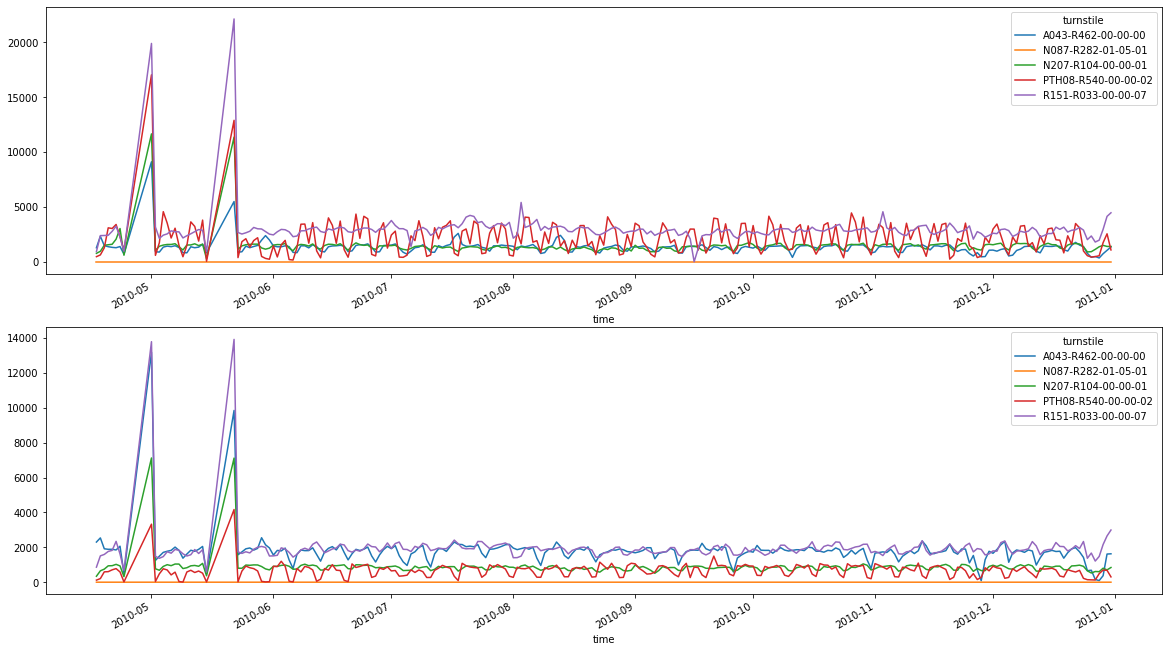

In [173]:
fig, axes = plt.subplots(2, 1, figsize=(20, 12))
axes = np.hstack(axes)

def plot_sample_turnstile(samples, ax, frequency='D'):

    columns = ['entries', 'exits']
    for ax, col in zip(axes, columns):
        df_agg_by_day = (
            df_grouped
                .loc[sampled_turnstile][col]
                .groupby([pd.Grouper(freq=frequency, level='time'), 'turnstile']).sum()
                .unstack(level='turnstile')
        )
        
        df_agg_by_day.plot(ax=ax)
        
plot_sample_turnstile(sampled_turnstile, axes, frequency='D')

That's nice. Notice I resampled data for a daily basis, so plots are easier to visualize.
For above plot we can start to see a pattern in our data regarding seasonality. Also, and more importat right now, we have two peaks around end of may/april of 2010. This is 8x the normal value for a daily basis, maybe something happened, or is it just a mistake? We need to further investigate that.

Since we have freedom to choose best configuration for our data, I will resample all information in a daily basis so I don't suffer from memory constraints because I am working on a single notebook. Also, I have uploaded data to a postgres database so can extract a new dataset resampling as desired withouth loading all data into memory. In this way I can load all data information for a longer period and we can check at once inconsistencies for this time frame.

In [174]:
df_agg_by_day = (
    df_grouped
        .loc[sampled_turnstile]['entries']
        .groupby([pd.Grouper(freq='D', level='time'), 'turnstile']).sum()
        .unstack(level='turnstile')
    )

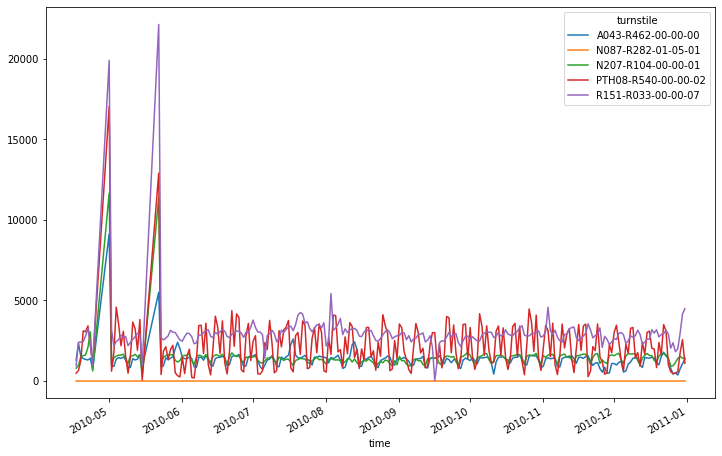

In [175]:
df_agg_by_day.plot(figsize=(12, 8));

Let's continue checking our data for any inconsistency.

In [177]:
df_grouped.describe()

,entries,exits
count,7.415978e+06,7.415978e+06
mean,6.771046e+01,6.148442e+01
std,3.604284e+04,8.361076e+04
min,-1.844666e+07,-1.342177e+08
25%,3.000000e+00,2.000000e+00
50%,5.300000e+01,4.000000e+01
75%,2.080000e+02,1.520000e+02
max,1.844666e+07,1.342177e+08


That's weird, I have negative measurements for entries and exits, this shouldn't happen because it is cumulative column, let's dig into that.

In [178]:
def print_neg_info(df):
    print(f"Percentage of negative entries: {(df[df['entries'] < 0].shape[0] / df.shape[0])*100}")
    print(f"Percentage of negative exits: {(df[df['exits'] < 0].shape[0] / df.shape[0])*100}")

print_neg_info(df_grouped)

Percentage of negative entries: 0.010471156209705589
Percentage of negative exits: 0.009891671374419438


In [57]:
example = df[(df['turnstile']=='PTH17-R541-01-00-02')].set_index('time').loc['2010-12-10':'2010-12-31']
example.join(example['entries'].diff().to_frame(name='entries_diff'))

,ca,unit,scp,station,linename,division,desc,entries,exits,turnstile
time,,,,,,,,,,
2010-04-17 04:36:57,PTH17,R541,01-00-02,THIRTY THIRD ST,1,PTH,REGULAR,0.0,738920.0,PTH17-R541-01-00-02
2010-04-17 08:48:57,PTH17,R541,01-00-02,THIRTY THIRD ST,1,PTH,REGULAR,0.0,739037.0,PTH17-R541-01-00-02
2010-04-17 13:00:57,PTH17,R541,01-00-02,THIRTY THIRD ST,1,PTH,REGULAR,0.0,739190.0,PTH17-R541-01-00-02
2010-04-17 17:12:57,PTH17,R541,01-00-02,THIRTY THIRD ST,1,PTH,REGULAR,0.0,739761.0,PTH17-R541-01-00-02
2010-04-17 21:38:57,PTH17,R541,01-00-02,THIRTY THIRD ST,1,PTH,REGULAR,0.0,740519.0,PTH17-R541-01-00-02
...,...,...,...,...,...,...,...,...,...,...
2010-12-31 06:43:59,PTH17,R541,01-00-02,THIRTY THIRD ST,1,PTH,REGULAR,0.0,1203152.0,PTH17-R541-01-00-02
2010-12-31 10:55:59,PTH17,R541,01-00-02,THIRTY THIRD ST,1,PTH,REGULAR,0.0,1203266.0,PTH17-R541-01-00-02
2010-12-31 15:07:59,PTH17,R541,01-00-02,THIRTY THIRD ST,1,PTH,REGULAR,0.0,1203524.0,PTH17-R541-01-00-02


**Update1**:

The example above demonstrates what happens in our data.

 - 2010-12-30 16:57:06	R262B	R195	05-00-02	161 ST-YANKEE	4BD	IRT	TS	0.0	0.0	R262B-R195-05-00-02	-163938.0
 
Sometimes the turnstile is zeroed, making huge amounts. I've noticed with other examples that also we have non-regular auditios in turnstiles and recovered ones, which makes measurement unreliable. As I need to take a decision, I will check percentiles so I can clip data to filter out these inconsistencies in our data.

In [9]:
def print_percentiles(df):
    for col in ['entries', 'exits']:
        lower, upper = np.percentile(df[col].dropna().values, [1, 99.99])
    
        print(f"Percentiles for 1 and 99th are: {lower} - {upper}")
    
print_percentiles(df_resampled)

Percentiles for 1 and 99th are: 0.0 - 4747.0
Percentiles for 1 and 99th are: 0.0 - 4250.0


Applying this rule I think it is the fastest and more reliable way to resample our data. If a just resample it, we would get a lot of days with negative values (As I have tested), and if I would decide further to resample it in a higher frequency, the problem would just propagate.

**Update2**: Although above rule seemed to solve the negative values, I would still face cases where the measurement went to zero and then came back to normal, giving huge amounts, therefore the best approach is to replace every value higher than 99th percentile with 0. I am aware that I am replacing some true values, by they are minimal, and the trade-off between getting most of data correct is or whole data correct looks good for me.

Now let's preprocess all csv files so we can use them and see whole series. For modularity purposes, I have done it in a script called preprocess and saved under scripts/ folder.

In [1]:
# preprocess <filename> <frequency>
!python ../scripts/preprocess.py {2010..2017}.csv.gz D

08/09/2020 12:53:40:INFO:Starting program.
08/09/2020 12:53:40:INFO:Processing file for year: 2010
08/09/2020 12:53:40:INFO:Loading csv file 2010.csv.gz to memory.
08/09/2020 12:53:55:INFO:Creating df with diff calculation for entries and exits.
08/09/2020 12:55:31:INFO:Removing inconsistencies for series.
08/09/2020 12:55:31:INFO:Negative values and higher than 10,000 being replaced by zero for entries
08/09/2020 12:55:31:INFO:Negative values and higher than 10,000 being replaced by zero for exits
08/09/2020 12:55:31:INFO:Capping outliers after removing inconsistencies.
08/09/2020 12:55:31:INFO:Clipping outliers for entries. Boundary values: (0, 1163.0)
08/09/2020 12:55:31:INFO:Clipping outliers for exits. Boundary values: (0, 1117.0)
08/09/2020 12:55:31:INFO:Resampling data to frequency: D
08/09/2020 12:55:32:INFO:Merging resampled data set with original one to get station, linename, and division columns
08/09/2020 12:55:34:INFO:Saving new preprocessed data.
08/09/2020 12:55:51:INFO:

In [4]:
df_resampled = pd.concat(map(functools.partial(pd.read_csv, engine='c', parse_dates=['time']), 
                             glob.glob('../data/preprocessed/*.csv.gz')))
df_resampled = df_resampled.set_index(['turnstile', 'time'])

df_resampled.shape

(12060679, 5)

Let's plot again the turnstile from above to confirm our data remains correct.

In [7]:
df_resampled.loc[sampled_turnstile].unstack(level='turnstile')['entries'].plot(figsize=(20, 12));

NameError: name 'sampled_turnstile' is not defined

Now we have whole series and we can resample as we wish, for example, we can see in a specific turnstile total number of entries and exits in a specific month.

<AxesSubplot:xlabel='time'>

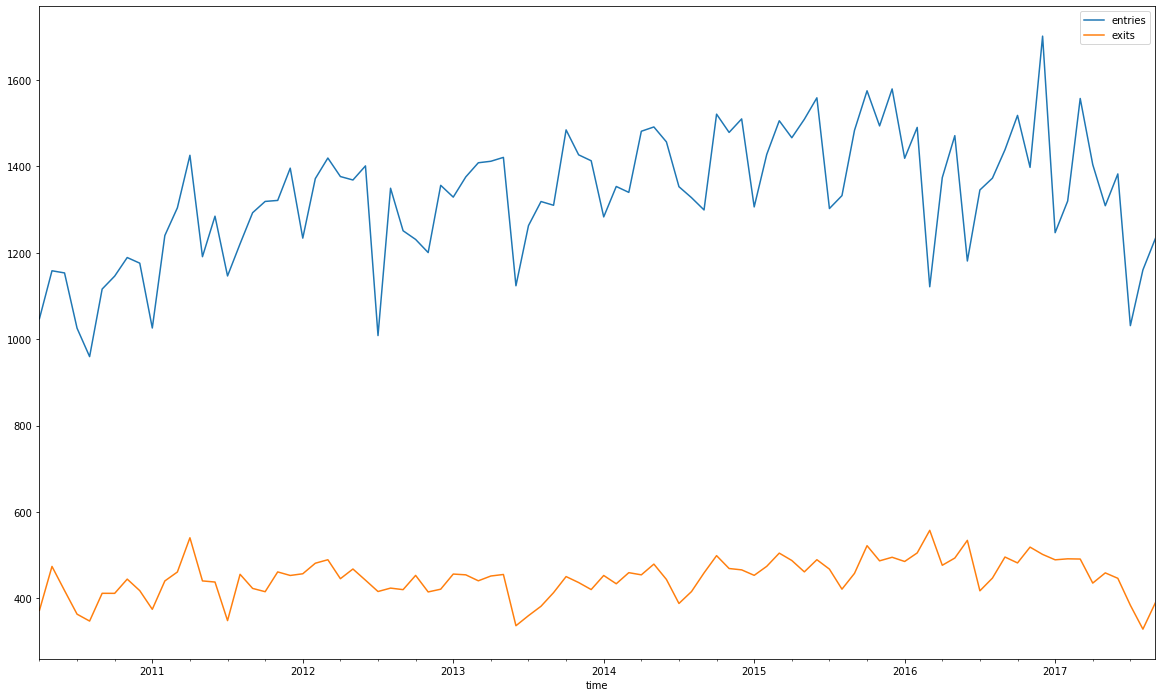

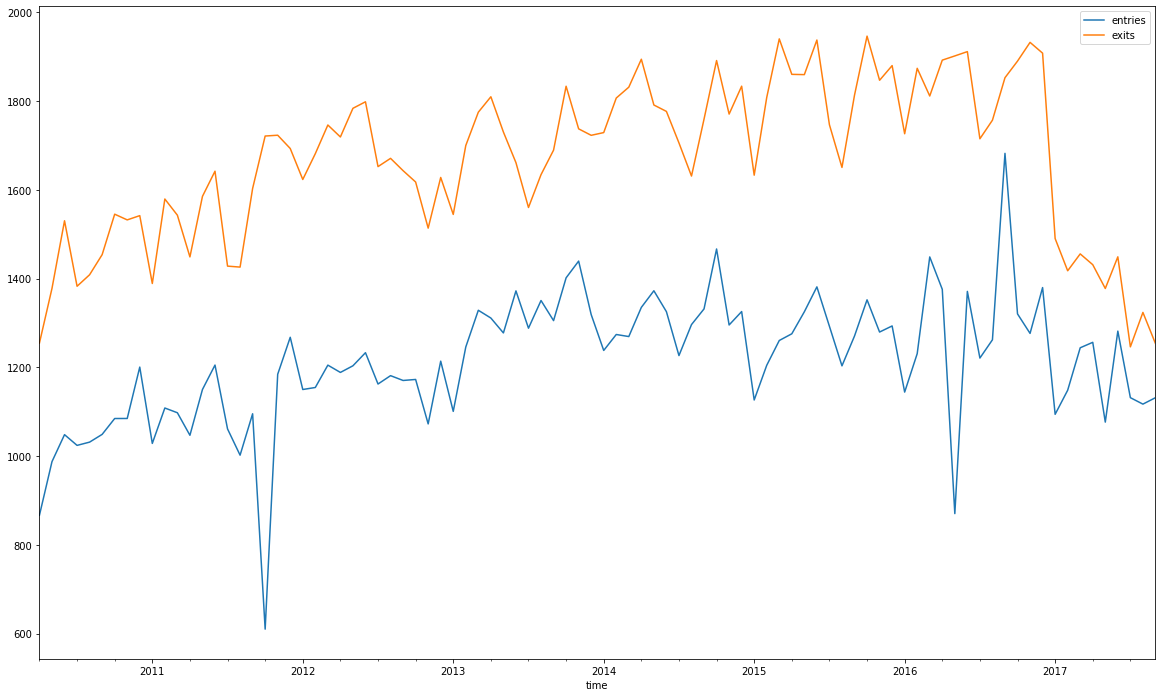

In [19]:
df_resampled.loc[('A002-R051-02-00-00')].resample('M').mean().plot(figsize=(20, 12))
df_resampled.loc[('A002-R051-02-03-02')].resample('M').mean().plot(figsize=(20, 12))

Now that I processed all data, removed so far inconsistencies and outliers, and aggregate it by day, let's continue our data preparation step. Previously, we were able to fill missing values using df_remote_names dataframe, let's try out with whole series now.

In [5]:
df_resampled.isnull().sum()

entries         0
exits           0
station     77771
linename    77771
division    77771
dtype: int64

In [6]:
turnstiles_missing_cols = df_resampled[df_resampled['station'].isnull()].index.get_level_values('turnstile').unique()
len(turnstiles_missing_cols)

131

We have 131 different turnstile with missing station, linename and division, let's count only remote.

In [7]:
remote_missing_cols = set(map(lambda x: x.split('-')[1], turnstiles_missing_cols))
len(remote_missing_cols)

10

Just a few, let's see if these values are present in remote_names data frame.

In [8]:
df_remote_names[df_remote_names['remote'].isin(remote_missing_cols)]['remote'].unique().shape

(9,)

9 out of 10, this seems pretty good, let's look into data. Also, we need booth column to match with ca columns so we can get correct values. However, I've noticed manipulating data that sometimes ca has an additional letter either in original and remote_names frames, so I need to merge frames using a pattern match, rather than traditional merge, let's try out.

In [9]:
df_resampled['remote'] = list(map(lambda x: x.split('-')[1], df_resampled.index.get_level_values('turnstile')))
df_resampled['ca'] = list(map(lambda x: x.split('-')[0], df_resampled.index.get_level_values('turnstile')))

In [11]:
def remove_last_char(string):
    if len(string) > 4:
        return string[:-1]
    return string

df_remote_names['ca'] = df_remote_names['ca'].apply(remove_last_char)
df_resampled['ca'] = df_resampled['ca'].apply(remove_last_char)

In [12]:
remote_missing_cols

{'R001',
 'R014',
 'R028',
 'R057',
 'R088',
 'R168',
 'R194',
 'R202',
 'R508',
 'R538'}

In [13]:
df_resampled.shape

(12060679, 7)

In [14]:
def merge_and_fill_nulls(df, df_remote):

    df_turnstiles = (
        df
        .reset_index()
        .merge(df_remote.drop_duplicates(subset=['remote', 'ca']), 
                on=['remote', 'ca'], 
                how='left',
                suffixes=('', '_fill'))
        .assign(station=lambda df: df['station'].fillna(value=df['station_fill']),
                linename=lambda df: df['linename'].fillna(value=df['linename_fill']),
                division=lambda df: df['division'].fillna(value=df['division_fill']))
        .drop(['station_fill', 'linename_fill', 'division_fill'], axis=1)
        .set_index(['turnstile', 'time'])
        )
    
    return df_turnstiles

df_turnstiles = merge_and_fill_nulls(df_resampled, df_remote_names)

# deleting resampled frame to not run out of memory in notebook
del df_resampled
gc.collect()

df_turnstiles.shape

(12060679, 7)

In [15]:
df_turnstiles.head(5)

,,entries,exits,station,linename,division,remote,ca
turnstile,time,,,,,,,
A002-R051-02-00-00,2015-01-01,429.0,149.0,LEXINGTON AVE,NQR456,BMT,R051,A002
A002-R051-02-00-01,2015-01-01,375.0,88.0,LEXINGTON AVE,NQR456,BMT,R051,A002
A002-R051-02-03-00,2015-01-01,210.0,621.0,LEXINGTON AVE,NQR456,BMT,R051,A002
A002-R051-02-03-01,2015-01-01,550.0,838.0,LEXINGTON AVE,NQR456,BMT,R051,A002
A002-R051-02-03-02,2015-01-01,497.0,623.0,LEXINGTON AVE,NQR456,BMT,R051,A002


As we can see, we have the same dataset so we ar enot duplicating rows using left join as above. Let's check the new count on nulls now.

In [16]:
df_turnstiles.isnull().sum()

entries         0
exits           0
station     51841
linename    51841
division    51841
remote          0
ca              0
dtype: int64

That's nice, we were able to diminish the null values. But we still have some left out, let's check dataframe again to see if we can find any pattern that will help us.

In [17]:
df_turnstiles[df_turnstiles['station'].isnull()].head(5)

,,entries,exits,station,linename,division,remote,ca
turnstile,time,,,,,,,
A077-R028-03-00-00,2014-01-01,142.0,271.0,NaN,NaN,NaN,R028,A077
A077-R028-03-00-01,2014-01-01,159.0,248.0,NaN,NaN,NaN,R028,A077
A077-R028-03-00-02,2014-01-01,125.0,214.0,NaN,NaN,NaN,R028,A077
A077-R028-03-03-00,2014-01-01,140.0,53.0,NaN,NaN,NaN,R028,A077
A081-R028-04-00-00,2014-01-01,20.0,42.0,NaN,NaN,NaN,R028,A081


In [18]:
df_turnstiles[(df_turnstiles['station'].notnull()) & (df_turnstiles['remote']=='R028')].head(5)

,,entries,exits,station,linename,division,remote,ca
turnstile,time,,,,,,,
A077-R028-03-00-00,2015-01-01,94.0,40.0,FULTON ST,ACJZ2345,BMT,R028,A077
A077-R028-03-03-00,2015-01-01,87.0,236.0,FULTON ST,ACJZ2345,BMT,R028,A077
A077-R028-03-03-01,2015-01-01,0.0,192.0,FULTON ST,ACJZ2345,BMT,R028,A077
A077-R028-03-03-02,2015-01-01,128.0,128.0,FULTON ST,ACJZ2345,BMT,R028,A077
A081-R028-04-00-00,2015-01-01,40.0,73.0,FULTON ST,ACJZ2345,BMT,R028,A081


As we can see above, we have for a few rows with null values that can be filled using rows from other years. That is, we can use our own dataset to create (remote, ca) > station, linename, division rule.

In [19]:
df_remote_names_from_df = (
    df_turnstiles
        .loc[:, ['remote', 'ca', 'station', 'linename', 'division']]
        .drop_duplicates()
        .reset_index(drop=True)
)

df_remote_names_from_df.head(4)

,remote,ca,station,linename,division
0,R051,A002,LEXINGTON AVE,NQR456,BMT
1,R079,A006,5 AVE-59 ST,NQR,BMT
2,R079,A007,5 AVE-59 ST,NQR,BMT
3,R080,A010,57 ST-7 AVE,NQR,BMT


In [20]:
df_turnstiles.shape

(12060679, 7)

In [21]:
df_turnstiles = merge_and_fill_nulls(df_turnstiles, df_remote_names_from_df)
df_turnstiles.shape

(12060679, 7)

In [22]:
df_turnstiles.isnull().sum()

entries     0
exits       0
station     6
linename    6
division    6
remote      0
ca          0
dtype: int64

Wow, from 70_000 rows to 6, that's huge. With only 6 rows of undefined station, I can drop them that will not affect my models.

In [23]:
df_turnstiles = df_turnstiles.dropna()
df_turnstiles.shape

(12060673, 7)

The person reading this notebook will find me a little crazy, I've spent almost two days of work to prepare this data, and I did'nt even start my exploratory analysis. For me, getting the right data is crucial, I confess sometimes can be too much, but it is almost an OCD. Ok, then I have prepared this data and did this huge effort, but how can I know if any of this was worth? Fortunately, MTA publishes a few statistics than will help us to understand and check our data preparation, let's do that.

In [78]:
dfs_annual_ridership = (
    pd.read_html('http://web.mta.info/nyct/facts/ridership/ridership_sub_annual.htm')[2]
      .iloc[1:, :6]
      .rename(columns={"Station (alphabetical by borough)": "station"})
)

dfs_annual_ridership.head(5)

,station,2013,2014,2015,2016,2017
1,138 St-Grand Concourse,957984,1033559,1056380,1070024,1036746
2,149 St-Grand Concourse,4427399,4536888,4424754,4381900,4255015
3,161 St-Yankee Stadium,8766012,8961029,8922188,8784407,8596506
4,167 St,3081534,3067345,3180274,3179087,2954228
5,167 St,3091289,3245977,3295032,3365748,3293451


In this dataframe I have for five years total number of people who used that station in that specific year. I can use this information to validate my data. But before doing that, I need to do a little dataprep to make sure I have the same keys for station.

In [80]:
def prepr_station(station):
    station = station.replace('-', ' ')
    station = station.replace('AVE', 'AV')
    
    return station
    
prepr_station('161 ST-YANKEE STADIUM')

'161 ST YANKEE STADIUM'

In [81]:
prepr_station('1 AVE')

'1 AV'

In [29]:
dfs_annual_ridership.columns

Index(['Station (alphabetical by borough)', '2013', '2014', '2015', '2016',
       '2017'],
      dtype='object')

In [84]:
df_annual_ridership_by_station

,2013,2014,2015,2016,2017
station,,,,,
149 ST-GRAND CONCOURSE,4.427399e+06,4.536888e+06,4.424754e+06,4.381900e+06,4.255015e+06
161 ST-YANKEE STADIUM,8.766012e+06,8.961029e+06,8.922188e+06,8.784407e+06,8.596506e+06
167 ST,3.081534e+06,3.067345e+06,3.180274e+06,3.179087e+06,2.954228e+06
167 ST,3.091289e+06,3.245977e+06,3.295032e+06,3.365748e+06,3.293451e+06
170 ST,2.961575e+06,2.941958e+06,3.045205e+06,3.038777e+06,2.785331e+06
...,...,...,...,...,...
BRONX,1.491117e+08,1.525106e+08,1.523179e+08,1.530790e+08,1.492208e+08
MANHATTAN,9.403429e+08,9.653031e+08,9.703325e+08,9.663947e+08,9.555727e+08
QUEENS,2.456926e+08,2.506833e+08,2.523281e+08,2.527810e+08,2.431135e+08


In [89]:
df_annual_ridership_by_station = (
    dfs_annual_ridership
        .dropna()
        .assign(station=lambda df: df['station'].str.upper().apply(lambda row: prepr_station(row)))
        .set_index("station")
)

df_turnstiles['station'] = df_turnstiles['station'].str.upper().apply(lambda row: prepr_station(row))
df_annual_ridership_by_station.head(4)

<ipython-input-89-1c32bbda91d6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_turnstiles['station'] = df_turnstiles['station'].str.upper().apply(lambda row: prepr_station(row))


,2013,2014,2015,2016,2017
station,,,,,
138 ST GRAND CONCOURSE,957984,1033559,1056380,1070024,1036746
149 ST GRAND CONCOURSE,4427399,4536888,4424754,4381900,4255015
161 ST YANKEE STADIUM,8766012,8961029,8922188,8784407,8596506
167 ST,3081534,3067345,3180274,3179087,2954228


In [90]:
def convert_to_int(value):
    try:
        return np.int(value)
    except ValueError as e:
        print(e)
        return np.nan
    
df_annual_ridership_by_station = df_annual_ridership_by_station.applymap(convert_to_int)

invalid literal for int() with base 10: 'Brooklyn'
invalid literal for int() with base 10: 'Manhattan'
invalid literal for int() with base 10: 'Queens'
invalid literal for int() with base 10: 'Brooklyn'
invalid literal for int() with base 10: 'Manhattan'
invalid literal for int() with base 10: 'Queens'
invalid literal for int() with base 10: 'Brooklyn'
invalid literal for int() with base 10: 'Manhattan'
invalid literal for int() with base 10: 'Queens'
invalid literal for int() with base 10: 'Brooklyn'
invalid literal for int() with base 10: 'Manhattan'
invalid literal for int() with base 10: 'Queens'
invalid literal for int() with base 10: 'Brooklyn'
invalid literal for int() with base 10: 'Manhattan'
invalid literal for int() with base 10: 'Queens'


In [91]:
df_agg_by_station_year = (
    df_turnstiles
        .groupby(['station', pd.Grouper(freq='A', level='time')]).sum()
        .unstack(level='time')
)
        
df_agg_by_station_year.head(4)

entries                                                  \
time          2010-12-31  2011-12-31  2012-12-31  2013-12-31  2014-12-31   
station                                                                    
1 AV           4521801.0   6807585.0   7000640.0   7381612.0   7750796.0   
103 ST         7044824.0  10672222.0  10621997.0  11017299.0  10593251.0   
103 ST CORONA  3955990.0   6116179.0   6146458.0   6232461.0   6201894.0   
104 ST          519133.0    783258.0    765005.0    789519.0    833043.0   

                                                    exits             \
time          2015-12-31 2016-12-31 2017-12-31 2010-12-31 2011-12-31   
station                                                                
1 AV           7375377.0  7399688.0  4979720.0  4899737.0  7385788.0   
103 ST         9827808.0  9982741.0  7247067.0  5378779.0  7942864.0   
103 ST CORONA  6491762.0  6471890.0  4687436.0  3176410.0  4870372.0   
104 ST          728638.0  1288141.0   708739.0   432682.0   663275.0   

                                                                      \
time          2012-12-31 2013-12-31 2014-12-31 2015-12-31 2016-12-31   
station                                                                
1 AV           7459694.0  7696988.0  7993085.0  7552092.0  7168557.0   
103 ST         7760791.0  7616890.0  7454383.0  7188325.0  6338330.0   
103 ST CORONA  4738623.0  4782796.0  4666028.0  4842600.0  4805871.0   
104 ST          637071.0   615780.0   619632.0   449726.0   546701.0   

                          
time          2017-12-31  
station                   
1 AV           5119238.0  
103 ST         4879216.0  
103 ST CORONA  3481970.0  
104 ST          235634.0

Comparing with number of entries.

In [110]:
df_comparison_entries = (df_agg_by_station_year['entries'].iloc[:, 3:] / df_annual_ridership_by_station.groupby('station').sum().rename(columns=lambda x: f"{x}-12-31"))
df_comparison_entries.sample(20, random_state=42)

time,2013-12-31,2014-12-31,2015-12-31,2016-12-31,2017-12-31
station,,,,,
47 50 ST ROCK,NaN,NaN,NaN,NaN,NaN
KEW GARDENS UNION TURNPIKE,NaN,NaN,NaN,NaN,NaN
UNION ST,1.010412,1.010320,1.006030,1.008465,0.723511
25 AV,1.019929,1.021626,1.020967,1.016292,0.758484
ALLERTON AV,1.008549,0.970571,1.007070,1.006537,0.728492
CENTRAL PK N110,NaN,NaN,NaN,NaN,NaN
116 ST COLUMBIA,NaN,NaN,NaN,NaN,NaN
MYRTLE WYCKOFF,NaN,NaN,NaN,NaN,NaN
25 ST,1.012294,1.011118,1.005180,0.999750,0.721489


In [108]:
df_comparison_exits = (df_agg_by_station_year['exits'].iloc[:, 3:] / df_annual_ridership_by_station.groupby('station').sum().rename(columns=lambda x: f"{x}-12-31"))
df_comparison_exits.sample(20, random_state=42)

time,2013-12-31,2014-12-31,2015-12-31,2016-12-31,2017-12-31
station,,,,,
47 50 ST ROCK,NaN,NaN,NaN,NaN,NaN
KEW GARDENS UNION TURNPIKE,NaN,NaN,NaN,NaN,NaN
UNION ST,0.901024,0.910725,0.831580,0.820202,0.593699
25 AV,0.361862,0.331739,0.292758,0.232457,0.179825
ALLERTON AV,0.430110,0.401289,0.406941,0.378023,0.279571
CENTRAL PK N110,NaN,NaN,NaN,NaN,NaN
116 ST COLUMBIA,NaN,NaN,NaN,NaN,NaN
MYRTLE WYCKOFF,NaN,NaN,NaN,NaN,NaN
25 ST,0.981335,0.965896,0.848609,0.791785,0.582489


This seems excellent. So basically, the MTA group uses entries to count users in subway. Looking into their website, I confirmed this:

> Subway ridership consists of all passengers (other than NYC Transit employees) who enter the subway system, including passengers who transfer from buses.  **Ridership does not include passengers who exit the subway or passengers who transfer from other subway lines, with the exception of out-of-system transfers**; e.g., between the Lexington Av/63 St F subway F subway station and the Lexington Avenue N subway R subway W subway /59 St 4 subway5 subway6 subway station, where customers use their MetroCard to make the transfer.

So in our case study, forecasting number of users for nyc-metro data, entries are the best option since is aligned with what business do. This is the maximum information I can take in 'business understanding' since I can't talk directly for data owners.

Also, notice how 2017 column miss around 25% of data, probably it would be in a 2018.csv file with the rest of 2017 year.

In [126]:
df_comparison_entries.describe(percentiles=[0.1, 0.90])

time,2013-12-31,2014-12-31,2015-12-31,2016-12-31,2017-12-31
count,198.000000,198.000000,200.000000,234.000000,235.000000
mean,1.197533,1.165574,1.104146,1.050202,0.756824
std,1.197182,1.093681,0.633908,0.391976,0.222050
min,0.200843,0.197797,0.236545,0.580383,0.400767
10%,0.976681,0.950096,0.977296,0.974052,0.696303
50%,1.009632,0.986210,1.007143,1.008124,0.731265
90%,1.036576,1.022400,1.027458,1.023313,0.766152
max,15.077569,13.329236,6.221480,5.910745,3.019179


So, on average, for each station I got the right data following mta report with pretty good approximations for 10-90th percentiles. But for a few of them they are off by almost 50% or 600%. Like I said, I have spent a lot of time here, so I will just ignore and be satisfied with getting most of data correctly since I am doing a reverse engineering job.

Since this notebook became too big, I will use another one to start my exploratory analysis step.

In [128]:
df_turnstiles.to_parquet('../data/preprocessed/turnstiles_daily.parquet.gzip', compression='gzip')